# Setup

In [2]:
%matplotlib widget
%matplotlib inline
from model_fns import UncorrelatedTMS, CorrelatedTMS, AntiCorrelatedTMS, ComposedFeatureTMS, ToyModelConfig
from autoencoder_fns import AutoEncoder, AutoEncoderConfig

import ipywidgets as widgets
interact = widgets.interact
from plot_fns import w_cossim, w_enc
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import torch as t
from tqdm.notebook import tqdm
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
rootdir=pathlib.Path("./saved_models/")
rootdir.mkdir(exist_ok=True)

saes = []

In [3]:
def plot_sae(idx=0):
    sae, model = saes[idx]
    for instance in range(sae.cfg.n_inst):
        actvecs, argsacts = w_enc(model, sae, instance=instance)
        cossim, args = w_cossim(model.W, sae.W_dec[instance], sort=argsacts)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(4,2))
        im1 = ax1.imshow(cossim.squeeze(), cmap='RdYlBu_r', vmin=-1, vmax=1)
        im2 = ax2.imshow(actvecs.squeeze(), cmap='viridis', vmin=0, vmax=actvecs.max())
                    



In [4]:
def plot_schematic(model, encoder, savename=None):
    with t.inference_mode():
        big_batch = model.get_batch(10_000)
        output = model(big_batch)
        _, h_reconstruct, acts, _, _, _ = encoder(model.h)

    se = ((h_reconstruct - model.h)/model.h.norm(dim=1, keepdim=True)).pow(2).sum(dim=-1)
    mse = se.mean(dim=-1)
    l1 = encoder.cfg.l1_coeff*acts.abs().sum(dim=-1).mean(dim=-1)
    loss = mse + l1
    argsort = t.argsort(loss)


    fig = plt.figure(figsize=(6.5,2))
    ax1 = fig.add_axes([0, 0, 0.3, 1])
    ax2 = fig.add_axes([0.35, 0, 0.3, 1])
    ax3 = fig.add_axes([0.7, 0.5, 0.15, 0.5])
    ax4 = fig.add_axes([0.85, 0.5, 0.15, 0.5])
    ax5 = fig.add_axes([0.7, 0, 0.15, 0.5])
    ax6 = fig.add_axes([0.85, 0, 0.15, 0.5])
    axs = [ax2, ax3, ax4, ax5, ax6]
    full_axs = [ax1,] + axs
    for instance in argsort:
        feat_set_indx = 0
        feat_set_steps = np.cumsum(model.cfg.feat_sets)
        colors = [np.array((27,158,119))/255, np.array((217,95,2))/255] #colorbrewer dark2
        theta = t.arctan(model.W[0,1]/model.W[0,0])
        rotation = t.Tensor((t.cos(theta), -t.sin(theta), t.sin(theta), t.cos(theta))).reshape(2,2)
        labels = [r'$x_1$', r'$x_2$', r'$y_1$', r'$y_2$']
        for i in range(model.W.shape[0]):
            if model.cfg.feat_sets is not None and feat_set_steps[feat_set_indx] == i: 
                feat_set_indx += 1
            
            xs = np.array((0, (model.W@rotation)[i,0].item()))
            ys = np.array((0, (model.W@rotation)[i,1].item()))
            # ax1.plot(xs, ys, colors[feat_set_indx], '-')

            axs[instance].annotate("", xy=(xs[1], ys[1]), xytext=(xs[0], ys[0]), arrowprops=dict(arrowstyle="->", lw=3, color=colors[feat_set_indx]))
            ax1.annotate("", xy=(xs[1], ys[1]), xytext=(xs[0], ys[0]), arrowprops=dict(arrowstyle="->", lw=3, color=colors[feat_set_indx]))
        ax1.text((model.W@rotation)[0,0], 0.1 + (model.W@rotation)[0,1], labels[0], ha='center', va='center')
        ax1.text((model.W@rotation)[1,0], 0.1 + (model.W@rotation)[1,1], labels[1], ha='center', va='center')
        ax1.text(0.1 + (model.W@rotation)[2,0], (model.W@rotation)[2,1], labels[2], ha='center', va='center')
        ax1.text(0.1 + (model.W@rotation)[3,0], (model.W@rotation)[3,1], labels[3], ha='center', va='center')
        
        labels = [r'$f_1$', r'$f_2$', r'$f_3$', r'$f_4$']
            # axs[instance].plot(xs, ys, colors[feat_set_indx], '-')
        for j in range(encoder.cfg.d_sae):
            
            sae_xs = np.array((0, (encoder.W_dec@rotation)[instance,j,0].item()))
            sae_ys = np.array((0, (encoder.W_dec@rotation)[instance,j,1].item()))
            # axs[instance].plot(sae_xs, sae_ys, 'r-')
            axs[instance].annotate("", xy=(sae_xs[1], sae_ys[1]), xytext=(sae_xs[0], sae_ys[0]), arrowprops=dict(arrowstyle="->", lw=2, color='black'))

            x_off = [0, -0.125, 0, -0.1]
            y_off = [0, -0.1, -0.15, 0]
            if instance == 0:
                axs[instance].text(sae_xs[1] + x_off[j], sae_ys[1] + y_off[j], labels[j], ha='left', va='bottom')


    for ax in full_axs:
        ax.axhline(0, lw=0.5, c='k')
        ax.axvline(0, lw=0.5, c='k')
        ax.set_xlim(-1.1,1.1)
        ax.set_ylim(-1.1,1.1)
    for ax in [ax1, ax2]:
        ax.set_xticks((-1, 0, 1))
        ax.set_yticks((-1, 0, 1))

    for ax in axs[-4:]:
        ax.set_xticks(())
        ax.set_yticks(())
    
    if savename is not None:
        fig.savefig(savename, dpi=300, bbox_inches='tight')


In [5]:
def to_scientific(num, decimals=0):
    log10 = np.log10(num)
    prefix = num/10**np.floor(log10)
    return rf"{prefix:.{decimals}f}$\times 10^{{{int(np.floor(log10))}}}$"

def plot_grid(model, saes, filename=None):

    theta = t.arctan(model.W[0,1]/model.W[0,0])
    rotation = t.Tensor((t.cos(theta), -t.sin(theta), t.sin(theta), t.cos(theta))).reshape(2,2)


    fig, axs = plt.subplots(5,5,figsize=(6.5,6.5))
    
    for i, lr in enumerate([3e-5, 1e-4,3e-4, 1e-3, 3e-3]):
        for j, l1_coeff in enumerate([1e-2, 3e-2, 1e-1, 3e-1, 1e0]):
            ax = axs[i,j]
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            ax.set_xticks(())
            ax.set_yticks(())
            if j == 0:
                ax.text(-0.5, 0.5, f'lr={to_scientific(lr)}', ha='center', va='center', transform=ax.transAxes, rotation=90)
            if i == 0:
                ax.text(0.5, 1.05, rf'$\lambda$={l1_coeff}', ha='center', va='bottom', transform=ax.transAxes)
            #plot model
            feat_set_indx = 0
            feat_set_steps = np.cumsum(model.cfg.feat_sets)
            colors = [np.array((27,158,119))/255, np.array((217,95,2))/255] #colorbrewer dark2
            for k in range(model.W.shape[0]):
                if model.cfg.feat_sets is not None and feat_set_steps[feat_set_indx] == k: 
                    feat_set_indx += 1
                
                xs = np.array((0, (model.W@rotation)[k,0].item()))
                ys = np.array((0, (model.W@rotation)[k,1].item()))
                # ax1.plot(xs, ys, colors[feat_set_indx], '-')

                ax.annotate("", xy=(xs[1], ys[1]), xytext=(xs[0], ys[0]), arrowprops=dict(arrowstyle="->", lw=3, color=colors[feat_set_indx]))

            encoder = saes[i*5 + j][0]
            with t.inference_mode():
                monosemanticity = encoder.measure_monosemanticity(model)
                big_batch = model.get_batch(10_000)
                output = model(big_batch)
                _, h_reconstruct, acts, _, _, _ = encoder(model.h)

            se = ((h_reconstruct - model.h)/model.h.norm(dim=1, keepdim=True)).pow(2).sum(dim=-1)
            mse = se.mean(dim=-1)
            l1 = encoder.cfg.l1_coeff*acts.abs().sum(dim=-1).mean(dim=-1)
            loss = mse + l1
            argsort = t.argsort(loss)
            m_argsort = t.argsort(monosemanticity, descending=True)
            models = [argsort[0]]
            if m_argsort[0] != argsort[0]:
                models.append(m_argsort[0])

            colors = ['black', 'grey']
            lw = [2, 1]
            for z,instance in enumerate(models):
                for k in range(encoder.cfg.d_sae):
                    
                    sae_xs = np.array((0, (encoder.W_dec@rotation)[instance,k,0].item()))
                    sae_ys = np.array((0, (encoder.W_dec@rotation)[instance,k,1].item()))
                    # axs[instance].plot(sae_xs, sae_ys, 'r-')
                    ax.annotate("", xy=(sae_xs[1], sae_ys[1]), xytext=(sae_xs[0], sae_ys[0]), arrowprops=dict(arrowstyle="->", lw=lw[z], color=colors[z]))

    if filename is not None:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

# Simple Uncorrelated Model (2 hidden dims)



## Model


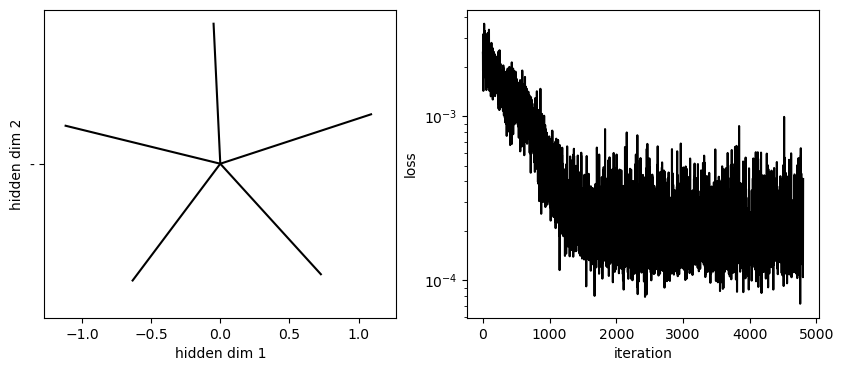

In [13]:
model_outputs = rootdir/'uncorrelated_models/'
model_outputs.mkdir(exist_ok=True)
Sparsity = 0.99
cfg = ToyModelConfig(
                    input_size=5, 
                    hidden_size=2, 
                    batches=5000, 
                    batch_size=1000,
                    sparsity = lambda N: Sparsity
                    )

model = UncorrelatedTMS(cfg).to(device)
model.train(outdir=model_outputs)



## SAE


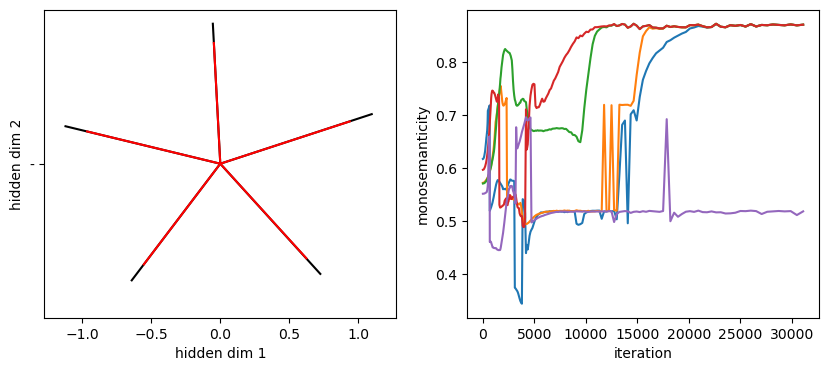

In [14]:
sae_outputs = rootdir/'uncorrelated_saes/'
sae_outputs.mkdir(exist_ok=True)

lr=1e-3
l1_coeff = 0.25

saes = []
#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                           n_inst=5,
                           training_samples = 32_000_000,
                            dict_mult=cfg.input_size/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False,
                           normalize_in_l2=False
                           )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
encoder.train(model,rootdir=sae_outputs)
saes.append(encoder)


# Simple Uncorrelated Model (5 hidden dims)



## Model


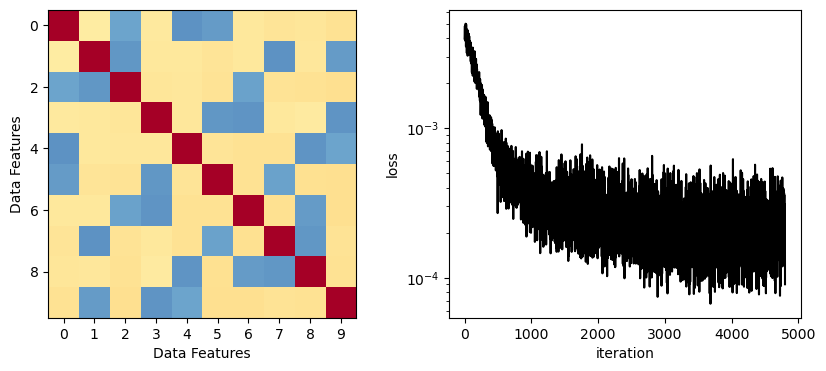

In [37]:
model_outputs = rootdir/'uncorrelated_models/'
model_outputs.mkdir(exist_ok=True)
Sparsity = 0.9
#We want feature 0 to have sparsity 0.9, and then later features to have sparsity -> 1 with a decay rate of 0.7
s_func = lambda i: Sparsity + (1-Sparsity)*(1-(2.7 + i)**(-1))

cfg = ToyModelConfig(
                    input_size=10, 
                    hidden_size=4, 
                    batches=5000, 
                    batch_size=1000,
                    sparsity = s_func
                    )

model = UncorrelatedTMS(cfg).to(device)
model.train(outdir=model_outputs)



## SAE


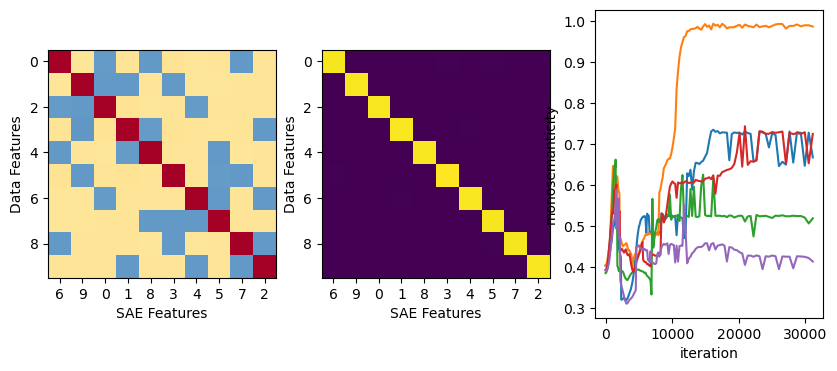

In [18]:
sae_outputs = rootdir/'uncorrelated_saes/'
sae_outputs.mkdir(exist_ok=True)

lr=1e-3
l1_coeff = 0.25

saes = []
#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                           n_inst=5,
                           training_samples = 32_000_000,
                            dict_mult=cfg.input_size/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False,
                           normalize_in_l2=False
                           )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
encoder.train(model,rootdir=sae_outputs)
saes.append(encoder)
